Importing necessary libraries and setting up the environment for a machine learning project. Using Pandas, NumPy, Seaborn, and Matplotlib for data manipulation and visualization. Employing PyTorch, Scikit-Learn, Hugging Face Transformers, and datasets library for machine learning tasks. AutoTokenizer and AutoModelForSequenceClassification from Transformers facilitate tokenization and model loading. The Trainer and TrainingArguments are employed for model training. The torchinfo library is used for summarizing model information. Warnings are suppressed using the warnings library. Overall, the environment is configured for efficient data processing, model training, and evaluation.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

%matplotlib inline

import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, mean_squared_error, confusion_matrix
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from torchinfo import summary

import warnings
warnings.filterwarnings('ignore')

In [2]:
dataframe = pd.read_csv('Tweets.csv')

dataframe.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
dataframe = dataframe[['airline_sentiment', 'text']].copy()

dataframe.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


Value Count For:  negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


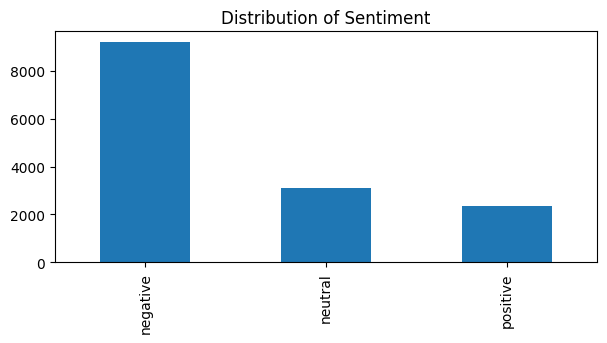

In [4]:

value_counts = dataframe['airline_sentiment'].value_counts()
print('Value Count For: ', value_counts)

value_counts = dataframe['airline_sentiment'].value_counts().plot(kind = 'bar', 
                                                                  title = 'Distribution of Sentiment', 
                                                                  figsize = (7, 3))

Filtering a DataFrame to exclude entries with 'neutral' sentiment, this Python script then computes and prints the value counts for each sentiment category. The resulting counts are visualized using a bar plot to illustrate the distribution of sentiments in the dataset.

Value Count For:  negative    9178
positive    2363
Name: airline_sentiment, dtype: int64


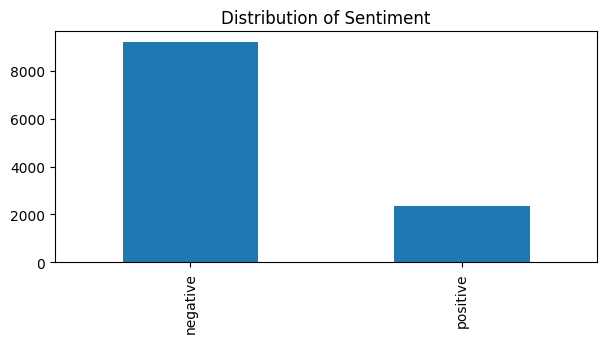

In [5]:
dataframe = dataframe[dataframe['airline_sentiment'] != 'neutral']

value_counts = dataframe['airline_sentiment'].value_counts()
print('Value Count For: ', value_counts)

value_counts.plot(kind='bar', title='Distribution of Sentiment', figsize=(7, 3))
plt.show()


In [6]:
target_map = {'positive':'1', 'negative':'0'}
dataframe['target'] = dataframe['airline_sentiment'].map(target_map)
dataframe.head()

,airline_sentiment,text,target
1,positive,@VirginAmerica plus you've added commercials t...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1


In [7]:
dataset = dataframe[['text', 'target']]
dataset.columns = ['sentence', 'label']
dataset.to_csv('data.csv', index = None)

In [8]:
data = load_dataset('csv', data_files = 'data.csv')
data

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 11541
    })
})

In [9]:
split = data['train'].train_test_split(test_size = 0.3, seed = 42)
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 8078
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 3463
    })
})

Loading a pre-trained DistilBERT model is accomplished by specifying the model checkpoint as 'distilbert-base-cased'. The Hugging Face AutoTokenizer is then used to create a tokenizer for the chosen checkpoint. This tokenizer is crucial for converting raw text data into tokenized sequences compatible with the DistilBERT model.

In [10]:
checkpoint = 'distilbert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Tokenizing the dataset involves defining a tokenize_function that utilizes the Hugging Face tokenizer with truncation. The function processes batches of sentences from the dataset. The actual tokenization is applied using split.map, ensuring efficient batch-wise processing. This step is essential for converting raw text into tokenized representations suitable for training a machine learning model.

In [11]:
def tokenize_function(batch):
    return tokenizer(batch['sentence'], truncation = True)

tokenized_dataset = split.map(tokenize_function, batched = True)

Map:   0%|          | 0/8078 [00:00<?, ? examples/s]

Map:   0%|          | 0/3463 [00:00<?, ? examples/s]

In [12]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels = 2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           1,538
├─Dropout: 1-4                                          --
Total params: 65,783,042
Trainable params: 65,783,042
Non-trainable params: 0

Training parameters for the Hugging Face Trainer involves setting key values. The output_dir designates the directory for storing model checkpoints and outputs. The evaluation_strategy and save_strategy are both set to 'epoch,' indicating evaluation and checkpoint saving at each epoch's end. num_train_epochs is set to 1, determining the total training epochs. per_device_train_batch_size and per_device_eval_batch_size are set to 16 and 64, respectively, defining batch sizes for training and evaluation on each device.

In [14]:
training_args = TrainingArguments(
    output_dir = 'training_dir',
    evaluation_strategy = 'epoch', 
    save_strategy = 'epoch', 
    num_train_epochs = 3, 
    per_device_train_batch_size = 16, 
    per_device_eval_batch_size = 64
    
)

Defining a compute_metrics function for use with the Hugging Face Trainer, this function takes the output of the model predictions and true labels as input and computes accuracy and F1 score. The Trainer is then initialized with the model, training arguments, tokenized training and evaluation datasets, tokenizer, and the defined compute_metrics function. The training process is executed using the trainer.train() method.

In [15]:
def compute_metrics(p):
    logits, labels = p
    predictions = np.argmax(logits, axis=-1)
    acc = np.mean(predictions == labels)
    f1 = f1_score(labels, predictions, average='macro')
    
    return {
        'accuracy': acc,
        'f1_score': f1,
    }

trainer = Trainer(
    model, 
    training_args, 
    train_dataset=tokenized_dataset['train'], 
    eval_dataset=tokenized_dataset['test'], 
    tokenizer=tokenizer, 
    compute_metrics=compute_metrics 
)

trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,0.230100,0.186905,0.930985,0.892269
2,0.104600,0.213905,0.937338,0.899663
3,0.042100,0.299654,0.941669,0.904355


TrainOutput(global_step=1515, training_loss=0.12443079866788569, metrics={'train_runtime': 11839.7545, 'train_samples_per_second': 2.047, 'train_steps_per_second': 0.128, 'total_flos': 303017104622496.0, 'train_loss': 0.12443079866788569, 'epoch': 3.0})

Generating predictions on the test dataset with a pre-trained model. The `trainer.predict` method is employed to obtain predictions. then predicted labels are determined by selecting the indices with the highest values along the last axis of the prediction array. The confusion matrix is then calculated, using `confusion_matrix` function, comparing the true and predicted labels.

In [16]:
predictions = trainer.predict(tokenized_dataset['test'])

predicted_labels = np.argmax(predictions.predictions, axis=-1)

true_labels = predictions.label_ids

conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[2712   78]
 [ 124  549]]


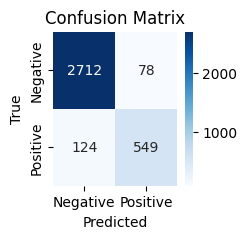

In [22]:
plt.figure(figsize=(2, 2))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()